In [2]:
import os
import sys

sys.path.append('../')

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from matplotlib import gridspec
from matplotlib.colors import Normalize
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torch.optim import Adam
from tqdm import tqdm

from kwave.ktransducer import kWaveGrid
from models.das import DAS
from models.joint_recon import Joint_Recon
from utils.data import *
from utils.dataset import get_jr_dataloader
from utils.reconstruction import *
from utils.simulations import get_water_SOS
from utils.utils_torch import get_total_params
from utils.visualization import *

os.environ["CUDA_VISIBLE_DEVICES"] = '0'

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

data_path = '../data/'
results_path = '../results/'

In [3]:
sinogram = load_mat(os.path.join(data_path, 'sinogram_simulation_easy.mat'))

SOS = load_mat(os.path.join(data_path, 'SOS.mat'))
SOS_SB = load_mat(os.path.join(data_path, 'SOS_SB.mat'))
SOS_body = load_mat(os.path.join(data_path, 'SOS_body.mat'))

Successfully loaded data from "../data/sinogram_simulation_easy.mat".
Successfully loaded data from "../data/SOS.mat".
Successfully loaded data from "../data/SOS_SB.mat".
Successfully loaded data from "../data/SOS_body.mat".


In [4]:
SOS[SOS>1499.37].mean(), SOS[SOS>1499.37].std()

(1571.6292634805807, 59.50190668134112)

In [5]:
Nx, Ny = 560, 560
dx, dy = 4e-5, 4e-5
kgrid = kWaveGrid([Nx, Ny], [dx, dy])
x_vec, y_vec = kgrid.x_vec, kgrid.y_vec
l = 3.2e-3 # Patch size [m].

In [6]:
R = 9.8e-3              # Radius of single body [m].
T = 26.0                # Water temperature [C].
v0 = get_water_SOS(T)   # Background SOS [m/s].
v1 = 1567.3             # Avergae SOS in single body [m/s].
print(v0, v1)

1499.3632858457756 1567.3


In [6]:
# fwhm = 1.5e-3 # [m]
# sigma = fwhm / 4e-5 / np.sqrt(2*np.log(2))
# gaussian_window = torch.tensor(gaussian_kernel(sigma, 80)).cuda()

In [7]:
das = DAS(R_ring=0.05, N_transducer=512, T_sample=1/40e6, x_vec=x_vec, y_vec=y_vec, mode='zero')
das.cuda()
das.eval()

DAS()

In [8]:
n_delays = 32
delays = np.linspace(-10e-4, 6e-4, n_delays)

In [9]:
img_stack = []
with torch.no_grad():
    for d_delay in tqdm(delays):
        recon = das(sinogram=torch.tensor(sinogram).cuda(), 
                    v0=torch.tensor(v0).cuda(),
                    d_delay=torch.tensor(d_delay).cuda(),
                    ring_error=torch.zeros(1).cuda())
        img_stack.append(recon)
img_stack = torch.stack(img_stack, dim=0)

100%|██████████| 32/32 [00:02<00:00, 10.89it/s]


In [10]:
img_stack = (img_stack - img_stack.mean()) / img_stack.std()

In [11]:
data_loader = get_jr_dataloader(img_stack, l, batch_size=1)

In [12]:
joint_recon = Joint_Recon(mode='SIREN', mean=1555, std=90, lam_tv=0.2e-11, #0.7e-3,
                          x_vec=x_vec, y_vec=y_vec, R=R, v0=v0, n_points=80, l=3.2e-3, n_delays=n_delays, angle_range=(0, 2*torch.pi))
joint_recon.cuda()
print("Number of parameter: %s" % (get_total_params(joint_recon)))

optimizer = Adam(params=joint_recon.parameters(), lr=2.e-5)

Number of parameter: 19073


In [13]:
n_epochs = 100
loss_list = []
for epoch in range(n_epochs):
    joint_recon.train()
    train_loss = 0.0
    for x, y, img in data_loader:
        x, y, img = x.cuda(), y.cuda(), img.cuda()
        rec_jr, SOS_jr, loss = joint_recon(x, y, img, torch.tensor(delays).cuda())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    loss_list.append(train_loss)
    print("Joint Reconstruction:  [{}/{}]  loss={:0.4g} ".format(epoch+1, n_epochs, train_loss/len(data_loader)))

In [ ]:
SOS_jr = SOS_jr.squeeze(0).squeeze(0).detach().cpu().numpy()
rec_jr = rec_jr.squeeze(0).squeeze(0).detach().cpu().numpy()

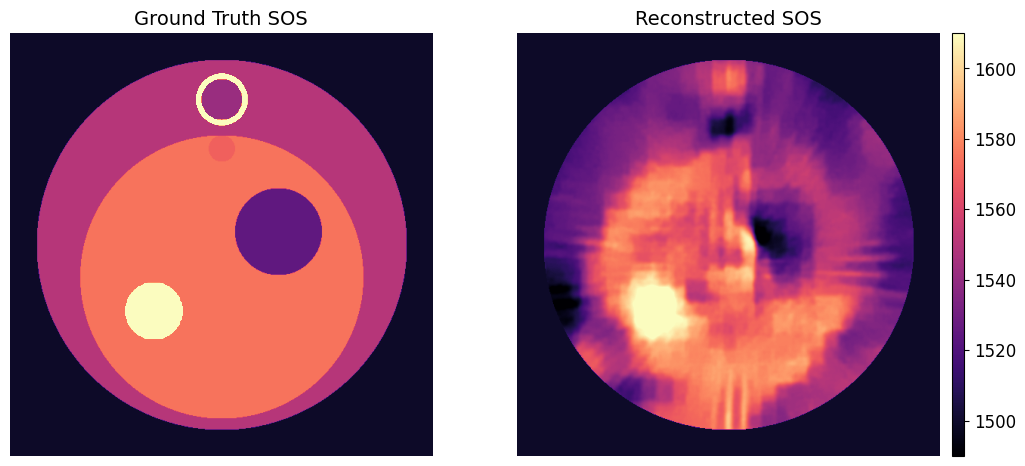

In [ ]:
fig = plt.figure(figsize=(12, 6))
norm = Normalize(vmax=1610, vmin=1490)

ax = plt.subplot(1, 2, 1)
plt.title('Ground Truth SOS', fontsize=14)
plt.imshow(SOS, norm=norm, cmap='magma')
plt.axis('off')

ax = plt.subplot(1, 2, 2)
plt.title('Reconstructed SOS', fontsize=14)
plt.imshow(SOS_jr, norm=norm, cmap='magma')
plt.axis('off')
cax = fig.add_axes([ax.get_position().x1+0.01, ax.get_position().y0, 0.01, ax.get_position().height])
cb = plt.colorbar(cax=cax, norm=norm)
cb.ax.set_yticks([1500, 1520, 1540, 1560, 1580, 1600])
cb.ax.tick_params(labelsize=12)

In [7]:
SOS.mean(), SOS.std(), SOS.max(), SOS.min()

(1542.8125135787627, 58.14416045488092, 1900.0, 1499.3632858457756)

In [ ]:
SOS_jr.mean(), SOS_jr.std(), SOS_jr.max(), SOS_jr.min()

(1530.6780720068473,
 32.096377599402594,
 1623.6219036579132,
 1482.0142441987991)

In [ ]:
save_mat(os.path.join(results_path, 'SOS_jr_simulation.mat'), SOS_jr.swapaxes(0,1), 'SOS')
# plt.imsave(os.path.join('../figures', 'SOS_jr_simulation.png'), SOS_jr, cmap='magma', vmin=1490, vmax=1610, dpi=100)

Successfully saved data to "../results/SOS_jr_simulation.mat".
